In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
from google.colab import files

In [2]:
# Unggah dataset
uploaded = files.upload()

Saving dataset_tempat_wisata_malang.csv to dataset_tempat_wisata_malang.csv


In [3]:
# Load dataset
data = pd.read_csv("dataset_tempat_wisata_malang.csv", sep=";")

In [4]:
# Konversi kolom 'rating', 'latitude', dan 'longitude' menjadi float
data['latitude'] = data['latitude'].str.replace(',', '.').astype(float)
data['longitude'] = data['longitude'].str.replace(',', '.').astype(float)

# Koordinat pusat kota (Alun-alun Malang)
center_lat, center_lon = -7.9826145, 112.6308113

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius bumi dalam km
    return c * r

# Hitung jarak
data['distance_to_center'] = haversine(data['latitude'], data['longitude'], center_lat, center_lon)

# Normalisasi jarak
scaler = MinMaxScaler()
data['distance_to_center'] = scaler.fit_transform(data[['distance_to_center']])

In [5]:
# Input dan output
X = data[['distance_to_center']].values
y = 1 / (1 + data['distance_to_center'].values)  # Skor relevansi (jarak terbalik)

# Bangun model
model = tf.keras.Sequential([
    layers.Input(shape=(X.shape[1],)),  # Jumlah fitur input
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Skor antara 0-1
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Training model
history = model.fit(X, y, epochs=10, batch_size=1, validation_split=0.2)

# Prediksi skor relevansi
predictions = model.predict(X)
data['predicted_score'] = predictions

# Tampilkan nama, jarak (asli), dan skor prediksi
# Denormalisasi jarak agar kembali ke skala asli
data['distance_to_center_km'] = scaler.inverse_transform(data[['distance_to_center']])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1169 - mae: 0.3167 - val_loss: 0.0365 - val_mae: 0.1581
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128 - mae: 0.0778 - val_loss: 0.0321 - val_mae: 0.1464
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091 - mae: 0.0674 - val_loss: 0.0061 - val_mae: 0.0695
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - mae: 0.0381 - val_loss: 0.0051 - val_mae: 0.0636
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - mae: 0.0317 - val_loss: 0.0046 - val_mae: 0.0606
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - mae: 0.0293 - val_loss: 0.0019 - val_mae: 0.0373
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9651e-04 - mae: 0.0273 - val_loss: 0.0019 - val_mae: 0.0381
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - mae: 0.0288 - val_loss: 6.9646e-04 - val_mae: 0.0235
Epoch 9/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

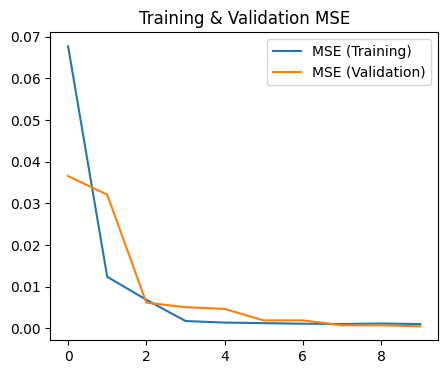

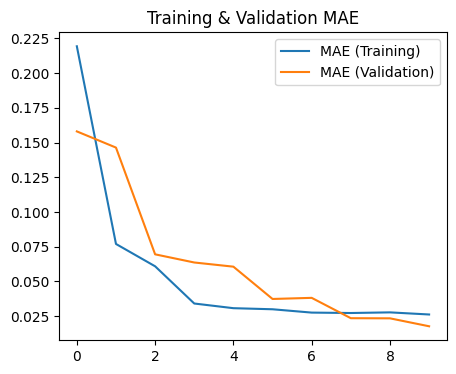

In [6]:
import matplotlib.pyplot as plt

# Plot MSE dan MAE selama training
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='MSE (Training)')
plt.plot(history.history['val_loss'], label='MSE (Validation)')
plt.legend()
plt.title('Training & Validation MSE')
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.legend()
plt.title('Training & Validation MAE')
plt.show()


In [7]:
# Output akhir
output = data[['name', 'distance_to_center_km', 'predicted_score']].sort_values(by='predicted_score', ascending=False)
print(output)

                             name  distance_to_center_km  predicted_score
2                Alun Alun Malang               0.000000         0.949308
104     Malang Jami' Grand Mosque               0.096790         0.949040
51            Sweetmemoriesselfie               0.204823         0.948740
25     Bis Wisata Malang (Macito)               0.360670         0.948305
27   Kajoetangan Heritage Village               0.435230         0.948095
..                            ...                    ...              ...
163          Pantai Batu Bengkung              52.346097         0.633253
164           Pantai Banyu Meneng              53.470164         0.625943
198         Klenteng Eng An Kiong              57.522521         0.599132
149               Pantai Modangan              59.075322         0.588689
148          Pantai Tanjung Penyu              92.562866         0.360018

[200 rows x 3 columns]


In [8]:
# Menyimpan model ke file .h5
model.save('model.h5')

In [9]:
# Mengonversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TensorFlow Lite ke file .tflite
with open('model_relevansi_jarakkota.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpr8zyi42f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137924208297760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137924158767344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137924158774032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137924158771920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137924158771216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137924158775792: TensorSpec(shape=(), dtype=tf.resource, name=None)
